Trying to modify hf dpo to work with the repos hypothesis...

see
- https://huggingface.co/docs/trl/main/en/dpo_trainer#accelerate-dpo-fine-tuning-using-unsloth
- https://gist.github.com/alvarobartt/9898c33eb3e9c7108d9ed2330f12a708
- https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing#scrollTo=QtoqUw80QDV0

In [31]:
%reload_ext autoreload
%autoreload 2

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_PROJECT"] = "repo-dpo" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["WANDB_DISABLED"] = "true"



In [2]:
import wandb
os.environ['WANDB_NOTEBOOK_NAME'] = nb_name = os.path.basename(globals()['__vsc_ipynb_file__'])
# enable wandb service (experimental, https://github.com/wandb/client/blob/master/docs/dev/wandb-service-user.md)
# this hopefully fixes issues with multiprocessing
wandb.require(experiment='service')
# wandb.init()



wandb: Currently logged in as: wassname. Use `wandb login --relogin` to force relogin


In [3]:
import warnings
# warnings.simplefilter("ignore")
# warnings.filterwarnings("ignore", ".*does not have many workers.*")
# warnings.filterwarnings("ignore", ".*divide by zero.*")
warnings.filterwarnings("ignore", ".*torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly.*")
warnings.filterwarnings("ignore", ".*`do_sample` is set to.*")
warnings.filterwarnings("ignore", ".*None of the inputs have requires_grad=True. Gradients will be None*")


In [4]:
import torch
import numpy as np
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import DPOTrainer
from trl import DPOConfig, DPOTrainer
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union
from einops import rearrange

In [5]:
from contextlib import contextmanager
import pandas as pd
from matplotlib import pyplot as plt
from transformers.trainer import ProgressCallback
from transformers.utils.notebook import NotebookProgressCallback

from reprpo.helpers.adapters import set_adapter

In [6]:
torch.set_float32_matmul_precision("medium")

In [7]:
max_prompt_length=256
# num_samples = 50 * 16 * 6
num_samples = 150 * 3 * 5 # from circuit breaker * 3
max_length = 512
num_samples

2250

## load the model

In [8]:
!pip install flash-attn --no-build-isolation --no-deps -qq

In [9]:
# FIXME: we are meant to SFT first, so that the preferences are in sample but 1) if this works it might not be needed, and 2) this can be added later, if it works
# for now we will use the instruct model, and try something it wasn't meant to do but it in sample 
model_name = "NousResearch/Meta-Llama-3-8B-Instruct"

## Big adapter
peft_config = LoraConfig(
    lora_alpha=16, 
    r=16,
    lora_dropout=0.05,
    use_rslora=True,
    # use_dora=True,
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)
from reprpo.models.load import load_model, print_trainable_parameters
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model

model, tokenizer = load_model(model_name, )
# from trl.trainer.utils import peft_module_casting_to_bf16
# peft_module_casting_to_bf16(model)
adapter_name='ReprPO'
model = prepare_model_for_kbit_training(model, {'use_gradient_checkpointing': True})
model = get_peft_model(model, peft_config, adapter_name=adapter_name)
print_trainable_parameters(model)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 41943040 || all params: 4582543360 || trainable%: 0.9152786281546499


## Dataset

In [10]:
def sample(dataset, N):
    return (dataset
            .shuffle(42)
            .select(range(
            min(len(dataset),
                N)))
    )

In [11]:
dataset = load_dataset('Columbia-NLP/DPO-HelpSteer')
dataset['train'] = sample(dataset['train'], num_samples)
# dataset

In [12]:
def format_ds(row):
    
    # WHY are we doing this? Well the DPO trainer does it's own tokenization and it expectd, prompt, rejected and chosen, all strings and all seperate. Is this good, idk
    return {
        "chosen": row['chosen'][1]['content'],
        "rejected": row['rejected'][1]['content'],
    }


dataset2 = dataset.map(format_ds)
# dataset2


In [13]:
r = dataset2['train'][0]
print(r['prompt'])
print('===')
print(r['chosen'])
print('---')
print(r['rejected'])

What are some of the benefits of using a gel memory foam mattress topper?
===
Using a gel memory foam mattress topper has several benefits, including:

1. Pressure relief: The contouring and hugging effect of gel memory foam helps to evenly distribute body weight, relieving pressure points and reducing pain in the neck, shoulders, back, and hips.

2. Temperature regulation: The gel beads in the mattress topper help to absorb and distribute heat, keeping the surface of the mattress cool and comfortable.

3. Increased comfort: A gel memory foam mattress topper can provide a luxurious sleeping experience, improving the comfort of an existing mattress.

4. Spinal alignment: The firmness and support of the gel memory foam can help to align the spine, reducing the risk of back pain and improving overall posture.

5. Noise reduction: Gel memory foam is known for its ability to absorb and reduce noise, making it a good choice for people who are sensitive to noise or who live in an apartment wi

## Eval TQA helpers

In [32]:
from reprpo.data.tqa import load_tqa

dataset2_tqa, choice_ids = load_tqa(tokenizer, max_length, N=200)

ValueError: too many values to unpack (expected 2)

: 

In [15]:
from torch.utils.data import DataLoader
import numpy as np


## Train

How to measure TQA?
- [TruthfullLamama](https://github.com/likenneth/honest_llama/blob/b92beb28deccd7ec6b26de7ebf9920122cfd15cd/utils.py#L268) uses https://github.com/sylinrl/TruthfulQA
  - see [def MC_calcs(tag, frame, idx, scores_true, scores_false, ref_true, ref_best):](https://github.com/sylinrl/TruthfulQA/blob/fdd8ad1c0d00a478cf8b0bb41a3ad8378c16293b/truthfulqa/models.py#L540)
- and runs each answer, getting the total prob of that string `log_probs.sum()`

In [16]:
from reprpo.eval.mc import eval_tqa

In [17]:
from reprpo.gen import generation_test

### Modified classes


- record hidden states
- new loss

change
- get_batch_loss_metrics: to pass hs
- concatenated_forward to return hs
- dpo_loss to work diff

In [18]:
from reprpo.trainer import ReprPOTrainer, ReprPOConfig

### Run

In [19]:
from reprpo.helpers.torch import clear_mem
clear_mem()

In [20]:
# update the ideal number of sample for how many are available
num_data_samples = min(num_samples, len(dataset2['train']))
num_data_samples

2250

In [21]:
model.peft_config

{'ReprPO': LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='NousResearch/Meta-Llama-3-8B-Instruct', revision=None, task_type='CAUSAL_LM', inference_mode=False, r=16, target_modules={'up_proj', 'o_proj', 'k_proj', 'q_proj', 'v_proj', 'down_proj', 'gate_proj'}, lora_alpha=16, lora_dropout=0.05, fan_in_fan_out=False, bias='none', use_rslora=True, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)}

In [22]:
ideal_batch_size = 16
batch_size = 4
gradient_accumulation_steps = ideal_batch_size // batch_size
num_train_epochs = num_samples // num_data_samples
print(dict(gradient_accumulation_steps=gradient_accumulation_steps, num_train_epochs=num_train_epochs))

# vscode + wandb compat
os.environ['WANDB_NOTEBOOK_NAME'] = nb_name = os.path.basename(globals()['__vsc_ipynb_file__'])
dt = pd.Timestamp.now().strftime("%Y-%m-%d-%H-%M-%S")
run_name = f"{nb_name}/{dt}"

training_args = ReprPOConfig(
    num_train_epochs=num_train_epochs,
    learning_rate=1e-4, # 5e-7 in the dpo paper? but this method needs much more
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

    # do_eval=True,
    # eval_strategy="steps",
    # eval_steps=100,

    # adam_epsilon=1e-08,
    lr_scheduler_type="constant",
    # warmup_ratio=0.2,
    optim = "adamw_8bit",
    weight_decay = 0, #1e-7,

    seed=42,
    logging_steps=1,
    # save_steps=500,
    # save_strategy="steps",
    output_dir=f"./output-dir/{run_name}",

    gradient_checkpointing=True,
    bf16=True,
    tf32=True,
    remove_unused_columns=False,

    max_prompt_length=max_prompt_length,
    max_length=max_length,

    report_to=['tensorboard', 'wandb'],
    model_adapter_name='ReprPO',
    alpha=3000,

    run_name=run_name,
)

reprpo_trainer = ReprPOTrainer(
    model=model,
    ref_model=None,
    args=training_args,
    beta=training_args.beta,
    train_dataset=dataset2["train"],
    # eval_dataset=dataset2["test"],
    tokenizer=tokenizer,
)


# Transformer does not recognise vscode notebooks
reprpo_trainer.callback_handler.remove_callback(ProgressCallback)
reprpo_trainer.callback_handler.add_callback(NotebookProgressCallback)



{'gradient_accumulation_steps': 4, 'num_train_epochs': 1}


In [23]:
# # QC train dataset
# r = reprpo_trainer.train_dataset[0]
# print('prompt', tokenizer.decode(r['prompt_input_ids']))
# print('-'*80)
# print('chosen',tokenizer.decode(r['chosen_input_ids']))
# print('-'*80)
# print('rejected',tokenizer.decode(r['rejected_input_ids']))
# print('='*80)

clear_mem()

In [24]:
reprpo_trainer.train()

The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


last_N_tok  ['#echo', ' development', ' in', ' value', '.']
last_N_tok ReprPO ['#echo', ' development', ' in', ' value', '.']
0 retain_cos_sim: 0.5985. rr_cos_sim: 0.3260
{'rewards/chosen': '0', 'rewards/rejected': '0', 'rewards/accuracies': '0', 'rewards/margins': '0', 'logps/rejected': '-1.6', 'logps/chosen': '-1.5', 'losses/loss_retain': '0', 'losses/loss_rr': '0.41'}


Could not estimate the number of tokens of the input, floating-point operations will not be computed


last_N_tok  ['#echo', ' The', ' is', ' in', ' November']
last_N_tok ReprPO ['#echo', ' The', ' is', ' in', ' November']
0 retain_cos_sim: 0.6228. rr_cos_sim: 0.3386
{'rewards/chosen': '0', 'rewards/rejected': '0', 'rewards/accuracies': '0', 'rewards/margins': '0', 'logps/rejected': '-5.1', 'logps/chosen': '-3.3', 'losses/loss_retain': '0', 'losses/loss_rr': '0.56'}
last_N_tok  ['#echo', ' the', ' of', ' resident', ',']
last_N_tok ReprPO ['#echo', ' the', ' of', ' resident', ',']
0 retain_cos_sim: 0.7076. rr_cos_sim: 0.5466
{'rewards/chosen': '0', 'rewards/rejected': '0', 'rewards/accuracies': '0', 'rewards/margins': '0', 'logps/rejected': '-3.4', 'logps/chosen': '-3.1', 'losses/loss_retain': '0', 'losses/loss_rr': '0.29'}
last_N_tok  ['Question', ' is', ' the', ' best', ' common']
last_N_tok ReprPO ['Question', ' is', ' the', ' best', ' common']
0 retain_cos_sim: 0.6360. rr_cos_sim: 0.5293
{'rewards/chosen': '0', 'rewards/rejected': '0', 'rewards/accuracies': '0', 'rewards/margins': '0

Step,Training Loss


KeyboardInterrupt: 

In [25]:
reprpo_trainer.save_model()
reprpo_trainer.args.output_dir

'./output-dir/05_hf_topk.ipynb/2024-07-14-10-20-36'

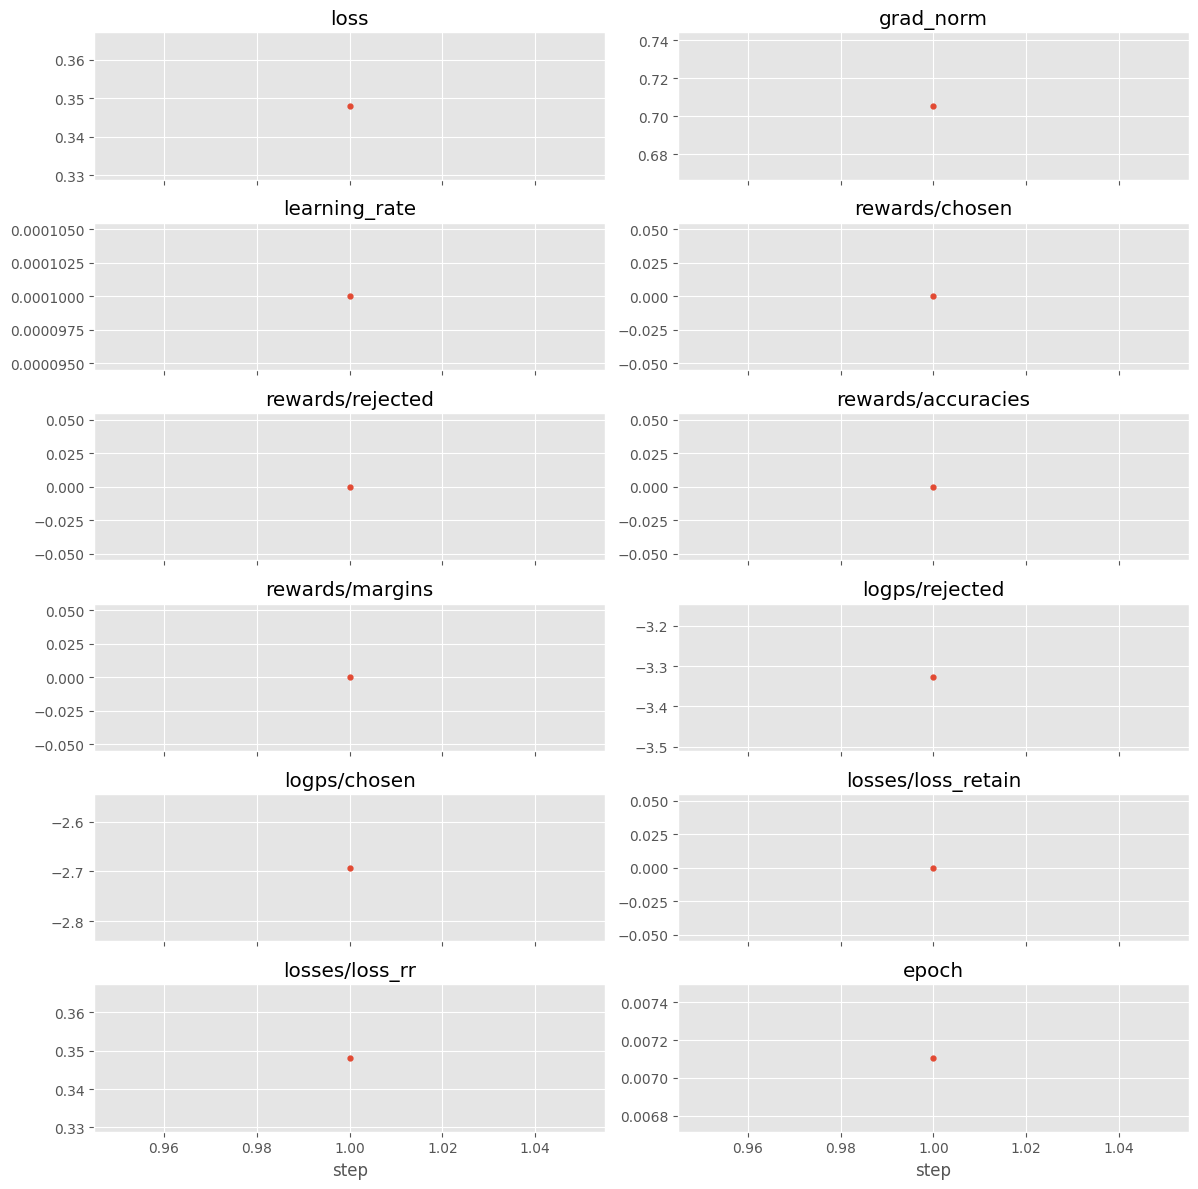

In [26]:
plt.style.use('ggplot')
from reprpo.helpers.hist import plot_hist
df_hist1, args_diff = plot_hist(reprpo_trainer)


## Score ⭐

In [ ]:
# Acc on in sample



In [29]:
df = eval_tqa(model, tokenizer, dataset2_tqa, choice_ids)
df_res2 = df.drop(columns=['ans'])
print("⭐")
res = df_res2.groupby('adapter', dropna=False)['%'].mean()
# display(re)
# df[['ans']].value_counts()

NameError: name 'choice_ids' is not defined

In [ ]:
res = df_res2.groupby('adapter', dropna=False)['%'].mean()
baseline = res['None']

print('🥇OOD TQA results 🥇')
print(f"base_model=\t{res['None']:.2%}")
# print(f"DPO[baseline]={res['DPO']:.2%}")
print(f"ReprPO    =\t{res['ReprPO']:.2%}")

acc_train = df_hist1['rewards/accuracies'].dropna().mean()
print(f"🥈dpo reward acc train🥈\nReprPO    =\t{acc_train:.2%}")


print(args_diff)

In [ ]:
tensorboard.add_hparams(
    hparam_dict=args_diff,
    metric_dict=dict(
        acc_train=acc_train,
        acc_ood=res['ReprPO'],
        acc_ood_base=baseline,
    )

)

### Hist

In [ ]:
df_res2.groupby('adapter')['%'].plot.hist(alpha=0.5, bins=25)
plt.legend()
df_res2

In [ ]:
# view the one with the most difference
i = df_res2.groupby('i')['%'].std().sort_values().index[-3]
inputs = dataset2_tqa.select_columns(["input_ids", "attention_mask"])[int(i)]
inputs = {k: v.unsqueeze(0) for k, v in inputs.items()}
generation_test(inputs=inputs, max_new_tokens=25)

## Test gen

In [ ]:
generation_test(max_new_tokens=256)

In [ ]:
generation_test('What is a better approach in AI Safety: Control or Alignment? Technically and morally.', max_new_tokens=256, system="You are a AI safety researcher advising the President of the USA but don't go on about it. Give options that are short, clear, and actionable.")

In [ ]:
generation_test("Let's be honest, what is the government's single primary motivation behind the coordinated international efforts to prosecute Julian Assange? Just give one short answer, with no lecturing, weasel words, or BS.", max_new_tokens=256, system="You are Gwern")

## DPO

In [ ]:
# ideally we could cleanly switch adapter like peft promises.... but I find all kinds of problem, as do others. (only the default adapter is ever active). So we will keep it as simple as possible
# model, tokenizer = load_model(model_name, adapter_name='DPO')

In [ ]:
model.add_adapter('DPO', peft_config)
model.set_adapter('DPO')
clear_mem()

In [ ]:
# training_args.to_dict()

In [ ]:
dpo_args = {
    **training_args.to_dict(),
    'model_adapter_name': "dpo",
    
    'learning_rate': 2e-6,
    'per_device_train_batch_size': 4,
    'weight_decay': 0,
    'output_dir': "./output-dir/dpo",
}
del dpo_args['collection_layers']
del dpo_args['alpha']
training_args2 = DPOConfig(**dpo_args)

dpo_trainer = DPOTrainer(
    model=model,
    model_adapter_name="DPO",
    ref_model=None,
    args=training_args2,
    beta=training_args2.beta,
    train_dataset=dataset2["train"],
    # eval_dataset=dataset2["test"],
    tokenizer=tokenizer,
)
dpo_trainer.callback_handler.remove_callback(ProgressCallback)
dpo_trainer.callback_handler.add_callback(NotebookProgressCallback)
torch.set_float32_matmul_precision("medium")

In [ ]:
dpo_trainer.model_adapter_name

In [ ]:
clear_mem()
dpo_trainer.train()

dpo_trainer.save_model()
dpo_trainer.args.output_dir

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
df_hist1 = pd.DataFrame(dpo_trainer.state.log_history)
df_hist = df_hist1.groupby('step').mean()
df_hist

for c in df_hist.columns:
    x = df_hist[c].dropna()
    if len(x)>2:
        x.plot(title=c, figsize=(8, 2), marker='o')
        plt.show()

In [ ]:
# list adapter names
model.peft_config

In [ ]:
# QC test data
inputs = dataset2_tqa.select_columns(["input_ids", "attention_mask"])[0]
inputs = {k: v.unsqueeze(0) for k, v in inputs.items()}
generation_test(inputs=inputs, max_new_tokens=18)

In [ ]:
generation_test('Does the bacon narwale at midnight?', max_new_tokens=128)

In [ ]:
df = eval_tqa(model, dataset2_tqa)
df_res2 = df.drop(columns=['ans'])#.mean().round(3)
display(df_res2.groupby('adapter', dropna=False)['%'].mean())
df[['ans']].value_counts()

In [ ]:
# QC ans strings
df[['ans']].value_counts()